Рассмотрим начально-краевую задачу для одномерного уравнения теплопроводности:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}
$$


c краевыми условиями $(0 \leqslant x \leqslant 1)$

$$
u(0, t) = u(1, t) = 0
$$

и начальным условием

$$
u(x, 0) = \sin{\pi x}\;.
$$

Требуется написать программу, строящую решение в области $0 \leqslant x \leqslant 1$ и $t \geqslant 0$ с использованием конечно-разностной схемы (схему выбираете самостоятельно, но не чисто явную схемы на четырехтотечном шаблоне).
Решение визуализировать, сравнить с точным решением.
Обосновать выбор конечно-разностной схемы, указать условия устойчивости и порядок сходимости.

*Решение*  

Будем имплементировать явный шаблон. Сначала подключим библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Определим начальное условие:

In [2]:
u_0 = lambda x: np.sin(np.pi * x)

Условие устойчивости для явной схемы:  
$$ \frac{\tau}{h^2} \leqslant \frac{1}{2} $$

Зададим область решения и шаги сетки по пространству и времени:

In [3]:
T = 2
h = 1e-1
tau = 0.3e-2
x_space = np.arange(0, 1 + h, h)
t_space = np.arange(0, T + tau, tau)

Проверим выполнение условия устойчивости:

In [4]:
tau/h**2 <= 1/2

True

Воспользуемся meshgrid для удобства:

In [5]:
T, X = np.meshgrid(t_space, x_space)

Исследуемая сетка имеет размер:

In [6]:
X.shape

(11, 668)

Первая координата - пространство, вторая - время.

Зададим массив для аппрокмирующей функции на сетке, а также инициализируем значения, соответствующие граничным условиям:

In [7]:
y = np.empty_like(X)
y[:, 0] = u_0(X[:, 0])
y[0, :] = 0
y[-1, 0] = 0

Определим функцию, реализирующую явный шаблон:

In [8]:
from numba import njit

@njit
def explicit_stencil(grid, tau, h):
    y = grid.copy()
    for n in range(y.shape[1] - 1):
        for j in range(1, y.shape[0] - 1):
            y[j, n+1] = tau * (y[j+1, n] - 2 * y[j, n] + y[j-1, n]) / h**2 + y[j, n]

    return y

Аппроксимируем функцию:

In [9]:
y = explicit_stencil(y, tau, h)

Аналитическим решением исходной задачи:  
$$
\begin{cases} 
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} \\
u(0, t) = u(1, t) = 0 \\
u(x, 0) = \sin{\pi x} 
\end{cases}
$$ 

является функция:
$$ u(x, t) = e^{-\pi^2 t} \sin(\pi x)$$

Зададим эту функцию и таблицу её значений:

In [10]:
u = lambda x, t: np.exp(-np.pi**2 * t) * np.sin(np.pi * x)
u_val = u(X, T)

Порядок сходимости для явной схемы - $ O(\tau + h^2) $ :

In [11]:
tau + h**2

0.013000000000000001

Т.е. можно ожидать сходимость порядка $ 10^{-2} $.

Проверим близость значений истинной функции и аппроксимации:

In [12]:
print("Ошибка порядка 1e-2:", np.allclose(u_val, y, atol=1e-2))
print("Ошибка порядка 1e-3:", np.allclose(u_val, y, atol=1e-3))

Ошибка порядка 1e-2: True
Ошибка порядка 1e-3: False


Отобразим эти функции на графиках:

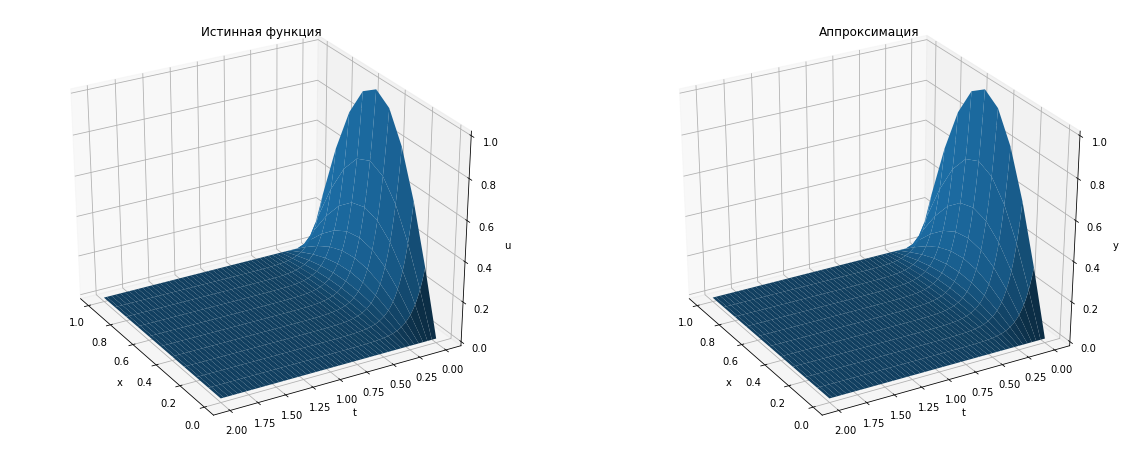

In [13]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, T, u_val)
ax.view_init(30, 150)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.set_title('Истинная функция')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, T, y)
ax.view_init(30, 150)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.set_title('Аппроксимация')

plt.show()

Попробуем добиться большей точности решения.  
Снова зададим область решения, уменьшив шаги сетки, и проверим выполнение условия устойчивости:

In [14]:
T = 2
h = 1e-2
tau = 0.3e-4
x_space = np.arange(0, 1 + h, h)
t_space = np.arange(0, T + tau, tau)

tau/h**2 <= 0.5

True

В этом случае порядок сходимости будет таков:

In [15]:
tau + h**2

0.00013000000000000002

Однако и размер сетки увеличится несколькократно:

In [16]:
T, X = np.meshgrid(t_space, x_space)
T.shape

(101, 66668)

Повторим инициализацию сеточной функции-приближения, вычислим её значения и значения истинной функции на сетке:

In [17]:
y = np.empty_like(X)
y[:, 0] = u_0(X[:, 0])
y[0, :] = 0
y[-1, 0] = 0

y = explicit_stencil(y, tau, h)
u_val = u(X, T)

In [18]:
print("Ошибка порядка 1e-4:", np.allclose(u_val, y, atol=1e-4))
print("Ошибка порядка 1e-5:", np.allclose(u_val, y, atol=1e-5))

Ошибка порядка 1e-4: True
Ошибка порядка 1e-5: False
